# Field Analysis Deep Dive
This workbook will walk through the method of field analysis on a step-by-step basis to explain the underlying method. Some references will be made to the accompanying research article (J. Ranalli and W. Hobbs, PV Plant Equipment Labels and Layouts can be Validated by Analyzing Cloud Motion in Existing Plant Measurements, submitted 2023).

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from solartoolbox import spatial, field, signalproc

datafile = "data/sample_plant_2.h5"
pos_utm = pd.read_hdf(datafile, mode="r", key="latlon")

df_a = pd.read_hdf(datafile, mode="r", key="data_a")
df_b = pd.read_hdf(datafile, mode="r", key="data_b")

cmv_a = spatial.pol2rect(9.52, 0.62)
cmv_b = spatial.pol2rect(8.47, 2.17)


The data that we've read has a few different components. The first is the position of the combiners, which is stored in the `pos_utm` dataframe. This dataframe has the following columns:
- `E` - The eastward position of the combiner's centroid in UTM coordinates
- `N` - The northward position of the combiner's centroid in UTM coordinates

The second component is the dataframes for the two one hour periods. These dataframes consist of a single column for each combiner containing the time series for a one hour period period during which the cloud motion vector was relatively constant. The CMVs are manually specified here to save on computational time, with `cmv_a` corresponding to `data_a` and so on.  

# Calculation Process
The calculation is carried out for a single combiner at a time. We will term this combiner of interest the target, $P_1$. Our goal is to compute a prediction of the target's location, $P'_1$. The process is as follows:
1. Isolate time period of a fixed CMV, $V_A$. Compute the delay, $\tau_{A,i}$, between target time series and that for each other combiner, $P_{2,i}$. In this implementation, we do that by looking at the transfer function between $P_1$ and $P_{2,i}$ and finding the delay from the phase of the transfer function. 


The box below shows an example of the transfer function for a single pair of sensors, for a single CMV.

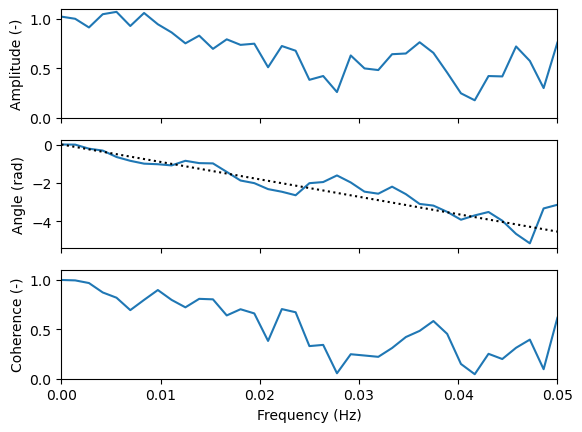

In [29]:
pt1 = 'CMB-015-1'
pt2 = 'CMB-015-6'
sig_in, sig_out = df_a[pt1], df_a[pt2]

# Calculate the TF
tf = signalproc.averaged_tf(sig_in, sig_out, navgs=5, overlap=0.5, window='hamming', detrend=None)

# Calculate the delay and a simulated TF with that delay
delay = signalproc.tf_delay(tf, coh_limit=0.6, freq_limit=0.02)[0]
fitline = signalproc.apply_delay(tf * 0 + 1, delay)

# Plot the results
fig, axs = plt.subplots(3,1, sharex=True)
axs[0].plot(tf.index, np.abs(tf['tf']))
axs[0].set_ylabel('Amplitude (-)')
axs[0].set_ylim([0, 1.1])
axs[1].plot(tf.index, np.unwrap(np.angle(tf['tf'])))
axs[1].plot(tf.index, np.unwrap(np.angle(fitline['tf'])), 'k:')
axs[1].set_ylabel('Angle (rad)')
axs[2].plot(tf.index, tf['coh'])
axs[2].set_ylabel('Coherence (-)')
axs[2].set_ylim([0,1.1])
axs[2].set_xlim([0, 0.05])
axs[2].set_xlabel('Frequency (Hz)')
plt.show()

A function is available in the `field` module to compute the delays for all points in a dataframe. This function is `field.compute_delays`. 

## Repeating across all secondary point
- This is repeated for all $P_{2,i}$ so that we have delays between every point and the target for the period with cloud motion $V_A$. A function for this purpose can be found in `field.compute_delays`.
- This process is also repeated for the second cloud motion vector, $V_B$

## Further steps
2. Based on the delay at known CMV, convert the delay into an apparent distance between $P_1$ and each $P_{2,i}$. This distance represents the projection of the vector from $P_1$ to $P'_{2,i}$ onto the CMV direction.
$$V * \tau = D_{||}$$ 
3. Compute the error vector according to equation x in the paper. The error vector represents the difference between the sites inferred from the cloud motion and that as expected frm the site plans. Thus, we also need to calculate the separation distance distance between the sensor pairs as specified in the site plan drawings, projected in the direction of the CMV.

In [30]:
ref = 'CMB-015-1'
combined_data = []
for df, cmv in zip([df_a, df_b], [cmv_a, cmv_b]):

    # Get the pairwise delays
    delay, coh = field.compute_delays(df, ref, 
                                      navgs=5,
                                      coh_limit=0.6,
                                      freq_limit=0.02)

    # Convert them to distances along the cloud motion vector
    delay_dist = -delay * spatial.magnitude(cmv)

    # Compute the actual separation distance for comparison
    # Negative gives dist from all points to ref, rather than vice versa
    pos_vecs = -spatial.compute_vectors(pos_utm['E'], pos_utm['N'],
                                        pos_utm.loc[ref][['E', 'N']])
    # Project the vec from point to ref into the cloud vector dir
    plan_dist = spatial.project_vectors(pos_vecs, cmv)

    error_dist = delay_dist - plan_dist['dist']

    # Aggregate
    pos_data = pd.DataFrame({'plan_dist': plan_dist['dist'],
                             'delay_dist': delay_dist,
                             'error_dist': error_dist,
                             'delay': delay,
                             'coh': coh},
                            index=pos_utm.index)
    combined_data.append(pos_data)

## Downselect the error vectors
The previous code computed an error vector for every possible site-pair combination. However, many of the site-pairs are sufficiently separated that the relationship between them is quite poor, meaning that the delays calculated may be highly uncertain. For the purposes of the study, we downselected to the 8 points for each CMV that had the highest low-frequency coherence in the transfer function. The error vectors for these points were averaged, resulting in an average inferred position of the sensor along each CMV. 

In [31]:
ndownsel = 8
coh1 = combined_data[0]['coh']
ix1 = coh1.sort_values().iloc[-ndownsel:-1].index
coh2 = combined_data[1]['coh']
ix2 = coh2.sort_values().iloc[-ndownsel:-1].index
combined_data = [combined_data[0].loc[ix1], combined_data[1].loc[ix2]]
e_a = np.mean(combined_data[0]['error_dist'])
e_b = np.mean(combined_data[1]['error_dist'])

## Computing the 2-D Position
From teh inferred error vectors e_a and e_b, we can now compute the location of the target point in 2-D space. This is done by finding the intersection of lines perpendicular to the two error vectors, and is implemented in `spatial.compute_intersection`.

Since the 2-D position is computed by considering the location of the target point as the origin, we then shift the position by the expected location of the reference point to obtain its absolute position.

In [32]:
pos = spatial.compute_intersection(
    np.array([spatial.pol2rect(e_a, spatial.rect2pol(*cmv_a)[1])]),
    np.array([spatial.pol2rect(e_b, spatial.rect2pol(*cmv_b)[1])])
)

pos = (pos + pos_utm.loc[ref].values).flatten()

In [33]:
pos

array([315.38582899, 819.96019098])

In [34]:
pos_utm.loc[ref]

E    305.275381
N    806.268157
Name: CMB-015-1, dtype: float64